# Data Import
1. iszero
2. nozero
3. nf (new feature)
---
- input featrue = 27
- 7일간 data를 하나의 instance화 한다면 -> input matrix 7 x 26 -> ouput matrix 7 x 1 (가격만 출력)
- 2148 row x 26 columns
- 다변량 시계열(multiivariate time series) 예측 system
- In our cousre DA, design for 단변량 시계열(univariate time series) prediction
- 2014.01.01~2020.12.31 data
- 건고추는 2014.01.22부터, 나머지는 대부분 2014.01.02부터

In [1]:
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc
%matplotlib inline
plt.rc('font', family='Malgun Gothic')

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, TimeSeriesSplit,GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.datasets import make_regression

from lightgbm import LGBMRegressor
from lightgbm import plot_importance 
from xgboost import XGBRegressor
from xgboost import plot_importance
import xgboost as xgb

#import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
path = "./Dataset/"
price_tag = ['건고추가격', '대파가격', '마늘가격', '무가격', '배추가격']

# is zero
isZero = pd.read_csv(path+"da_data.csv")

# no zero 
noZero = pd.read_csv(path+"da_data_nozero.csv")

# new features 
nf_peppers = pd.read_csv(path+"last건고추.csv" ,encoding='cp949')
nf_green_onion = pd.read_csv(path+"last대파.csv" ,encoding='cp949')
nf_garlic = pd.read_csv(path+"last마늘.csv" ,encoding='cp949')
nf_radish = pd.read_csv(path+"last무.csv" ,encoding='cp949')
nf_cabbage = pd.read_csv(path+"last배추.csv" ,encoding='cp949')

original_data_list = [nf_peppers, nf_green_onion, nf_garlic, nf_radish, nf_cabbage]

# Preproecssing 

1. outlier 
2. MinMaxScalar

input_data_list -> 0:건고추, 1:대파, 2:마늘, 3:무, 4:배추

In [4]:
def outliers_iqr(data, name) :
  print('원본 데이터 수 : ', len(data))

  Q1, Q3 = np.percentile(data[name], [25, 75])
  IQR = Q3 - Q1
  lower_bound = Q1 - (IQR * 1.5)
  upper_bound = Q3 + (IQR * 1.5)
  outlier_index = data[name][ (data[name] < lower_bound) | (data[name] > upper_bound) ].index.tolist()

  # 가격열 이상치 1일전/후 데이터의 평균값으로 대체
  num1list = [1] * len(outlier_index)
  outlier_pre = [outlier_index[i] - num1list[i] for i in range(len(outlier_index))]
  outlier_post = [outlier_index[i] + num1list[i] for i in range(len(outlier_index))]
  print(outlier_pre, '\n', outlier_post)

  outlier_sum = [data.loc[outlier_pre, name].tolist()[i] + data.loc[outlier_post, name].tolist()[i] for i in range(len(outlier_index))]
  num2list = [2] * len(outlier_index)
  outlier_result = [outlier_sum[i] / num2list[i] for i in range(len(outlier_index))]
  # print(data.loc[outlier_pre, name].tolist())
  # print(data.loc[outlier_post, name].tolist())
  # print(outlier_result)
  data.loc[outlier_index, name] = outlier_result
  #print(data)
  return data


def make_dataset(data, label, window_size):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)


def preprocessing(data, window_size, path) :
  # 0~1 정규화
  scaler = MinMaxScaler()
  scale_cols = data.iloc[:, 1:data.shape[1]].columns.tolist() # 날짜 제외한 모든 변수
  print('정규화 컬럼명 : ', scale_cols)

  scaled_data = scaler.fit_transform(data[scale_cols])
  scaled_data = pd.DataFrame(scaled_data)
  scaled_data.columns = scale_cols

  feature_cols = scaled_data.iloc[:, :scaled_data.shape[1]].columns.tolist() # 가격 포함
  label_cols = scaled_data.columns[0]
  print('X columns : ', feature_cols, '\nY column : ', label_cols)

  data_feature = scaled_data[feature_cols]
  data_label = scaled_data[label_cols]

  data_feature, data_label = make_dataset(data_feature, data_label, window_size)

  print('input shape : ', data_feature.shape, ', target shape : ', data_label.shape)

  return data_feature, data_label


def pre_processing(data) :
    scaler = MinMaxScaler()
    scale_cols = data.iloc[:,1:].columns
    
    data.sort_index(ascending=False).reset_index(drop=True)
    
    scaled = scaler.fit_transform(data[scale_cols])
    scaled = pd.DataFrame(scaled)
    scaled.columns = scale_cols
    
    return scaled

In [10]:
input_data_X = []
input_data_y = []
input_data_list = []

for data, tag in zip(original_data_list, price_tag) : 
    out_lier = outliers_iqr(data, tag)
    
    processed = pre_processing(out_lier)
    input_data_list.append(processed)
    
    X, y = preprocessing(out_lier, 7, path)
    input_data_X.append(X)
    input_data_y.append(y)

원본 데이터 수 :  2211
[1038, 1039, 1040, 1048, 1053, 1061, 1062, 1063, 1065, 1066, 1067, 1069, 1070, 1071, 1075, 1078, 1081, 1082, 1083, 1084, 1085, 1086, 1088, 1089, 1093, 1144, 1337, 1338, 1340, 1341, 1342, 1343, 1344, 1345, 1346, 1347, 1348, 1349, 1350, 1351, 1352, 1354, 1355, 1360, 1361, 1362, 1367, 1368, 1394, 1486, 1487, 1488, 1518, 1543, 1573, 1574, 1604, 1663, 1664, 1665, 1696, 1758, 1816, 1842, 1847, 1848, 1875, 1876, 1903, 1905, 1906, 1922, 1924, 1925, 1933, 1934, 1947, 1948, 1954, 2066, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2085, 2087, 2088, 2089, 2090, 2091, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2101, 2102, 2103, 2108, 2112, 2114, 2118, 2122, 2128, 2129, 2130, 2131, 2136, 2137, 2138, 2140, 2141, 2142, 2143, 2144, 2148, 2149, 2151, 2153, 2154, 2155, 2156, 2157, 2160, 2163, 2164, 2185, 2204] 
 [1040, 1041, 1042, 1050, 1055, 1063, 1064, 1065, 1067, 1068, 1069, 1071, 1072, 1073, 1077, 1080, 1083, 1084, 1085, 1086, 1087, 1088, 1090, 1091, 1

# Definition

In [11]:
def show_mse_rmse(test_y, pred) :
    mse = mean_squared_error(test_y, pred)
    print("mse : %f" % mse)
    
    rmse = np.sqrt(mse)
    print("rmse: %f \n" %rmse)


# prediction/actual 그래프 그리는 함수
def graph(pred, test_label) :
    plt.figure(figsize=(12, 6))
    #plt.plot(test_label, label = 'actual')
    plt.plot(test_label, label = 'actual', color='skyblue')
    #plt.plot(pred, label = 'prediction')
    plt.plot(pred, label = 'prediction', color='indianred')
    plt.legend()
    plt.show()


def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure(figsize=(12, 4))
  
  plt.subplot(1,2,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'], label = 'Val Error')
  plt.legend()
  
  plt.subplot(1,2,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
  plt.legend()
  plt.show()


def show_pred(test_y, pred) :
    true_y = test_y.to_numpy()
    true_y = np.ravel(true_y)
    
    df_result = pd.DataFrame(list(zip(true_y, pred)), columns=['true_y', 'prediction'])
    return df_result


def show_mse_rmse(test_y, pred) :
    mae = mean_absolute_error(test_y, pred)
    print("mae : %f" % mae)
    
    mse = mean_squared_error(test_y, pred)
    print("mse : %f" % mse)
    
    rmse = np.sqrt(mse)
    print("rmse: %f \n" %rmse)
    

def show_prediction_error(test_y, pred) :
    true_y = test_y.to_numpy()
    true_y = np.ravel(true_y)
    error = pred - true_y
    plt.hist(error, bins=50)
    plt.xlabel("Prediction Error")
    _ = plt.ylabel("Count")
    plt.savefig('savefig_default.png')


def feature_importance(model_xgb) : 
    %matplotlib inline
    plt.rcParams['axes.unicode_minus'] = False
    font_path = "C:/Windows/Fonts/NGULIM.TTF"
    font = fm.FontProperties(fname=font_path).get_name()
    rc('font', family=font)

    fig, ax = plt.subplots(figsize=(10,12))
    plt.savefig('savefig_default.png')
    plot_importance(model_xgb, ax=ax)


# For Graph
def view_original_price_graph(num) :
    plt.subplot(211)
    plt.plot(original_data_list[num][price_tag[num]])
    plt.subplot(212)
    plt.plot(input_data_list[num][price_tag[num]])
    plt.show()

def view_original_price_hist(num) : 
    plt.hist(original_data_list[num][price_tag[num]])
    plt.title('original price')
    plt.figure()
    plt.hist(input_data_list[num][price_tag[num]])
    plt.title('scaled price')
    plt.figure()
    plt.show()
    
def feature_importance(model_xgb) : 
    %matplotlib inline
    plt.rcParams['axes.unicode_minus'] = False
    font_path = "C:/Windows/Fonts/NGULIM.TTF"
    font = fm.FontProperties(fname=font_path).get_name()
    rc('font', family=font)

    fig, ax = plt.subplots(figsize=(10,12))
    plt.savefig('savefig_default.png')
    plot_importance(model_xgb, ax=ax)

# Modleing
1. model_xgb : 사이킷런 래퍼 클래스, 파이썬 래퍼 클래스 -> 사이킷런 기반 Estimator 상속 받아 작성, 사이킷런 래퍼 클래스로 구현 
2. model_lgbm 
3. model_rnn

In [44]:
# hyper parameter tuning 
WINDOW_SIZE = 7 # sequence
DATA_DIM = 26
OUTPUT_DIM = 1
learning_rate = 0.05
EPOCHS = 1000
mini_batch_size = 10
drop_out_value = 0.01
early_stop = EarlyStopping(monitor='val_loss', patience=20) # 조기종료 조건

class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

In [45]:
model_xgb =   XGBRegressor(n_estimators=1000, learning_rate=learning_rate)

model_lgbm = LGBMRegressor(n_estimators=1000, learning_rate=learning_rate)

model_rnn = keras.Sequential()           # input_shape = None 가능, RNN은 어떤 길이의 타입 step도 처리할 수 있기 때문
model_rnn.add(layers.SimpleRNN(units=1, activation='tanh', input_shape=[7,27])) # rnn 기본 activation function = tanh 
model_rnn.add(layers.Dense(1))                                                  

model_rnn.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate), metrics=['mae', 'mse'])

# 모델 구성 확인 
model_rnn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, 1)                 29        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 2         
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


# Training with TimeSeriesSplit

In [46]:
input_data = input_data_list[1]
X = input_data.iloc[:, 1:].to_numpy()
y = input_data.iloc[:, :1].to_numpy()


TRAIN 데이터셋 :  427 , TEST 데이터셋 :  423


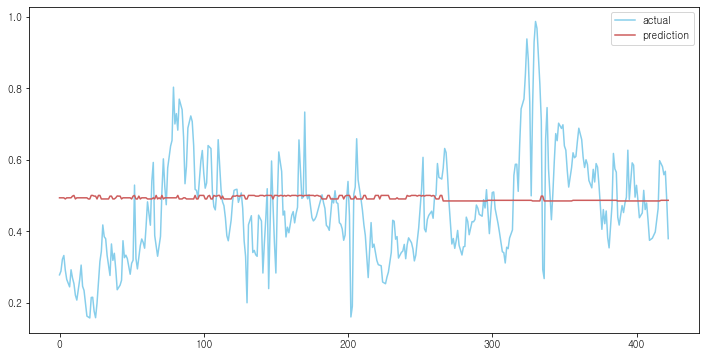

mae : 0.117600
mse : 0.021983
rmse: 0.148265 


TRAIN 데이터셋 :  850 , TEST 데이터셋 :  423


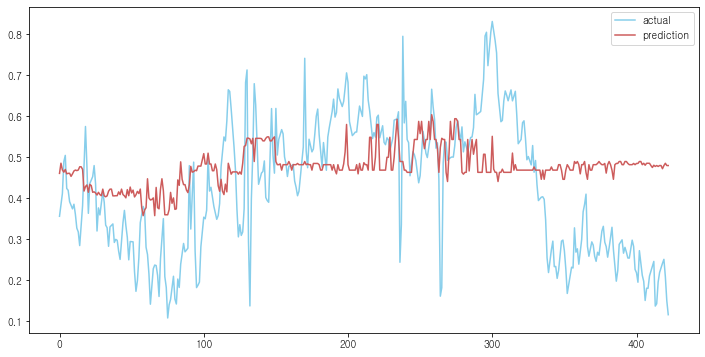

mae : 0.131751
mse : 0.025192
rmse: 0.158721 


TRAIN 데이터셋 :  1273 , TEST 데이터셋 :  423


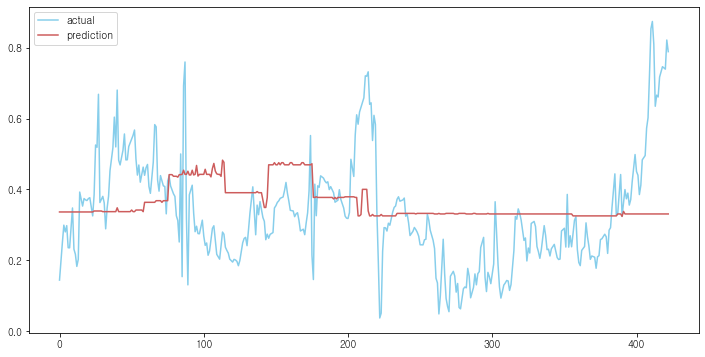

mae : 0.126302
mse : 0.025289
rmse: 0.159024 


TRAIN 데이터셋 :  1696 , TEST 데이터셋 :  423


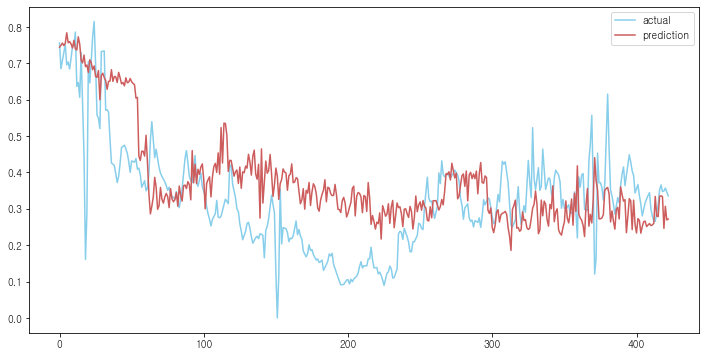

mae : 0.108249
mse : 0.017638
rmse: 0.132806 


TRAIN 데이터셋 :  2119 , TEST 데이터셋 :  423


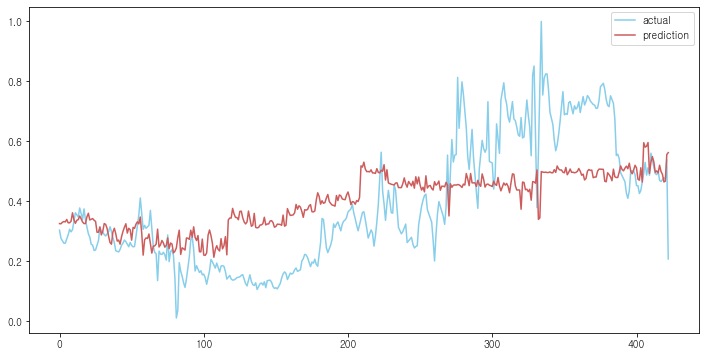

mae : 0.129835
mse : 0.025041
rmse: 0.158244 



In [47]:
tscv = TimeSeriesSplit(n_splits=5)
prediction = pd.DataFrame()

for train_index, test_index in tscv.split(X):
    train_X, test_X = X[train_index], X[test_index]
    train_y, test_y = y[train_index], y[test_index]
    print('\nTRAIN 데이터셋 : ', len(train_X), ', TEST 데이터셋 : ', len(test_X))

    evals = [(test_X, test_y)]
    model_xgb.fit(train_X, train_y, early_stopping_rounds=100, eval_metric="logloss", eval_set=evals, verbose=False)
    
    pred = model_xgb.predict(test_X)
    graph(pred, test_y)
    
    df_pred = pd.DataFrame(pred)
    prediction = pd.concat([prediction, df_pred], ignore_index=True)
    
    show_mse_rmse(test_y, pred)

## LGBM


TRAIN 데이터셋 :  427 , TEST 데이터셋 :  423


C:\Users\Hyeongbin\anaconda3\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Hyeongbin\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Hyeongbin\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Hyeongbin\

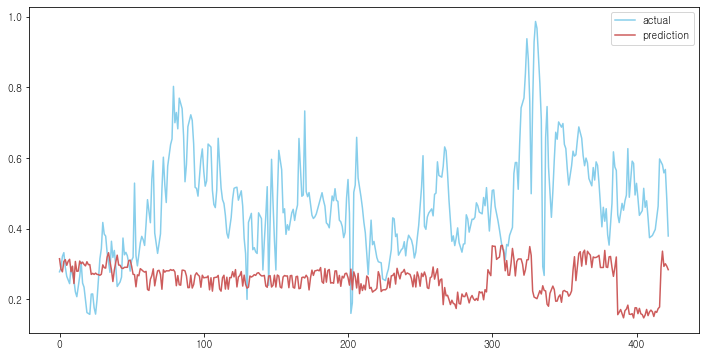

mae : 0.214300
mse : 0.065676
rmse: 0.256274 


TRAIN 데이터셋 :  850 , TEST 데이터셋 :  423


C:\Users\Hyeongbin\anaconda3\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Hyeongbin\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Hyeongbin\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Hyeongbin\

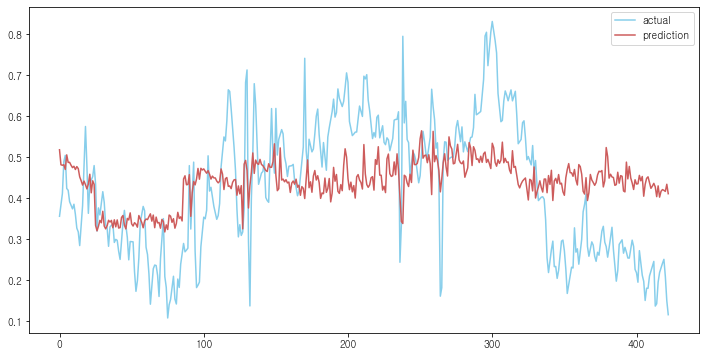

mae : 0.120922
mse : 0.021020
rmse: 0.144982 


TRAIN 데이터셋 :  1273 , TEST 데이터셋 :  423


C:\Users\Hyeongbin\anaconda3\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Hyeongbin\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Hyeongbin\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Hyeongbin\

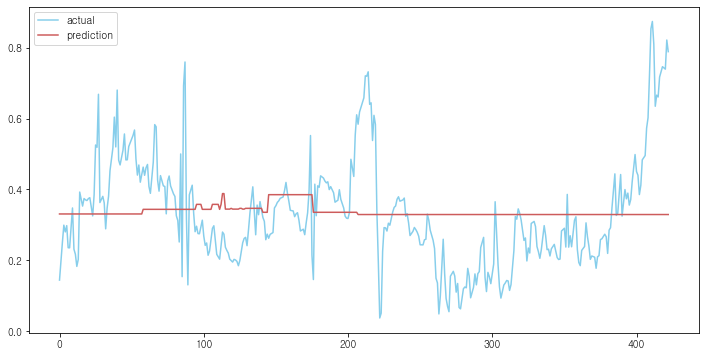

mae : 0.116197
mse : 0.023135
rmse: 0.152101 


TRAIN 데이터셋 :  1696 , TEST 데이터셋 :  423


C:\Users\Hyeongbin\anaconda3\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Hyeongbin\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Hyeongbin\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Hyeongbin\

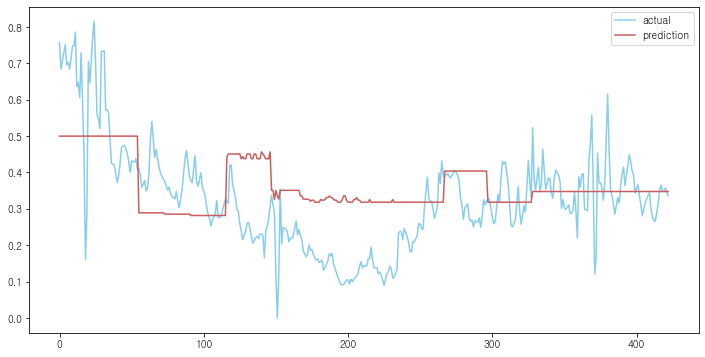

C:\Users\Hyeongbin\anaconda3\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Hyeongbin\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Hyeongbin\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Hyeongbin\

mae : 0.103548
mse : 0.016461
rmse: 0.128300 


TRAIN 데이터셋 :  2119 , TEST 데이터셋 :  423


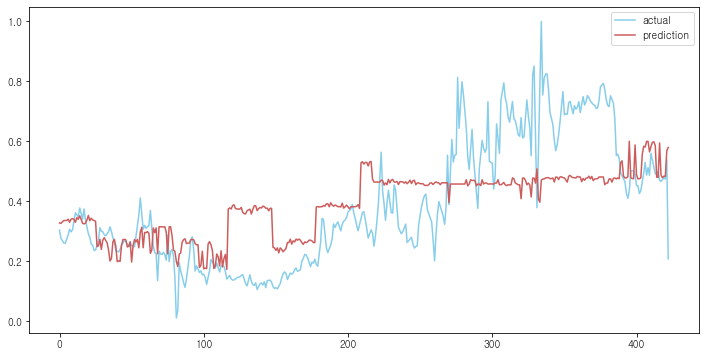

mae : 0.125465
mse : 0.024737
rmse: 0.157280 



In [48]:
tscv = TimeSeriesSplit(n_splits=5)
prediction = pd.DataFrame()

for train_index, test_index in tscv.split(X):
    train_X, test_X = X[train_index], X[test_index]
    train_y, test_y = y[train_index], y[test_index]
    print('\nTRAIN 데이터셋 : ', len(train_X), ', TEST 데이터셋 : ', len(test_X))

    evals = [(test_X, test_y)]
    model_lgbm.fit(train_X, train_y, early_stopping_rounds=100, eval_metric="logloss", eval_set=evals,verbose=False)
    
    pred = model_lgbm.predict(test_X)
    graph(pred, test_y)
    
    df_pred = pd.DataFrame(pred)
    prediction = pd.concat([prediction, df_pred], ignore_index=True)
    
    show_mse_rmse(test_y, pred)

## RNN


TRAIN 데이터셋 :  422 , TEST 데이터셋 :  422

....................................................................................................
........................................

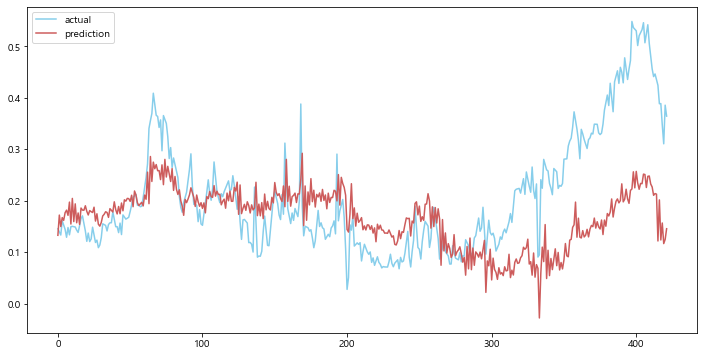

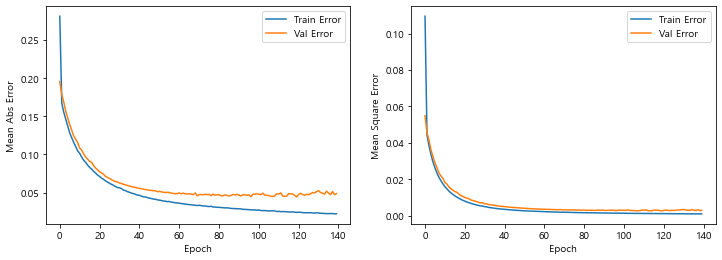

14/14 - 0s - loss: 0.0130 - mae: 0.0840 - mse: 0.0130
MAE:  0.083968
MSE:  0.012995
RMSE: 0.113995

TRAIN 데이터셋 :  844 , TEST 데이터셋 :  422

....................................................................................................
..................................................................

C:\Users\Hyeongbin\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Hyeongbin\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


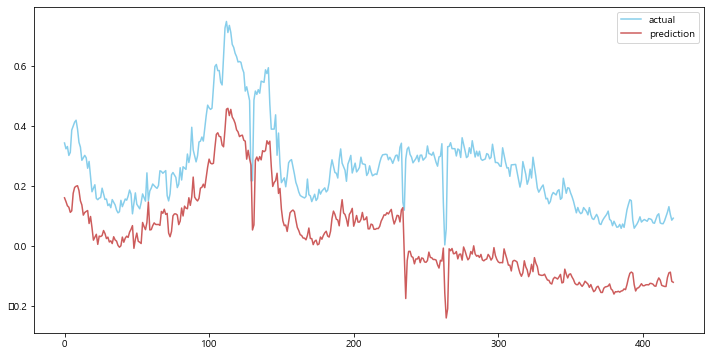

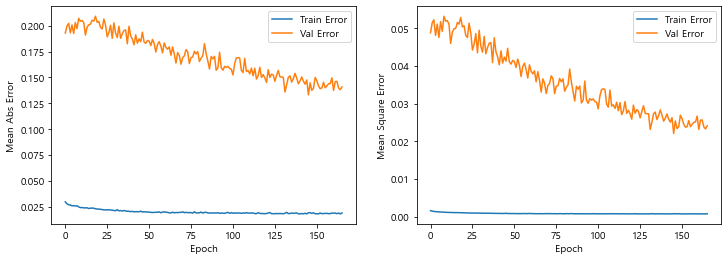

14/14 - 0s - loss: 0.0553 - mae: 0.2205 - mse: 0.0553
MAE:  0.220467
MSE:  0.055270
RMSE: 0.235096

TRAIN 데이터셋 :  1266 , TEST 데이터셋 :  422

.........................

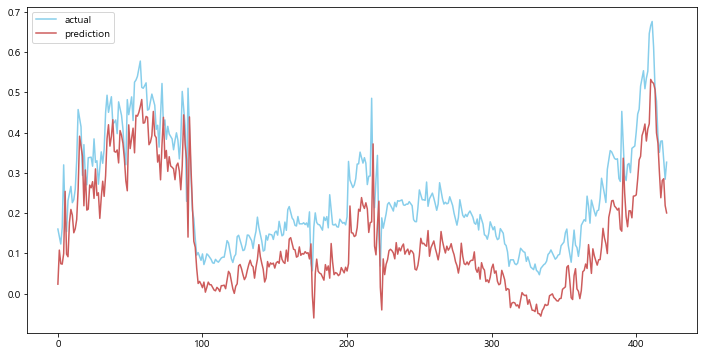

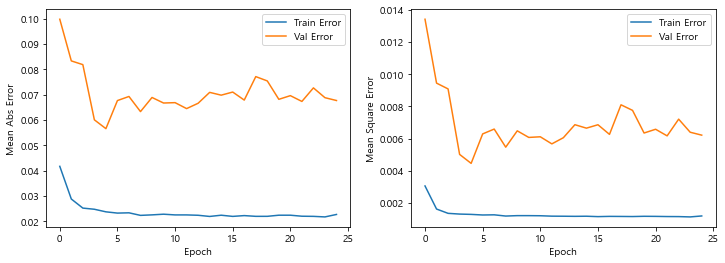

14/14 - 0s - loss: 0.0121 - mae: 0.1006 - mse: 0.0121
MAE:  0.100641
MSE:  0.012104
RMSE: 0.110018

TRAIN 데이터셋 :  1688 , TEST 데이터셋 :  422

...................................................

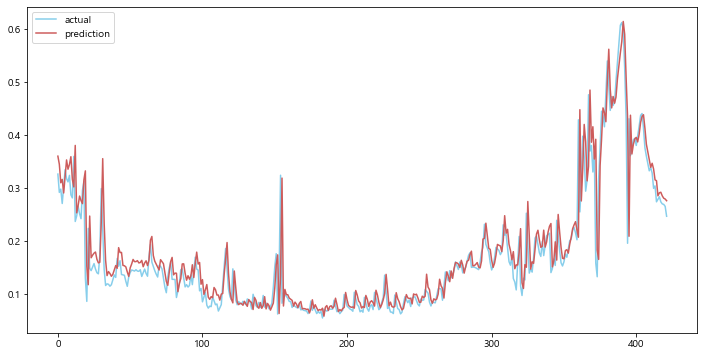

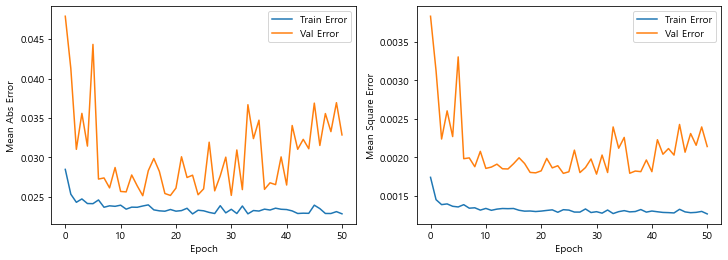

14/14 - 0s - loss: 0.0019 - mae: 0.0248 - mse: 0.0019
MAE:  0.024778
MSE:  0.001861
RMSE: 0.043144

TRAIN 데이터셋 :  2110 , TEST 데이터셋 :  422

....................................................................................................
....................

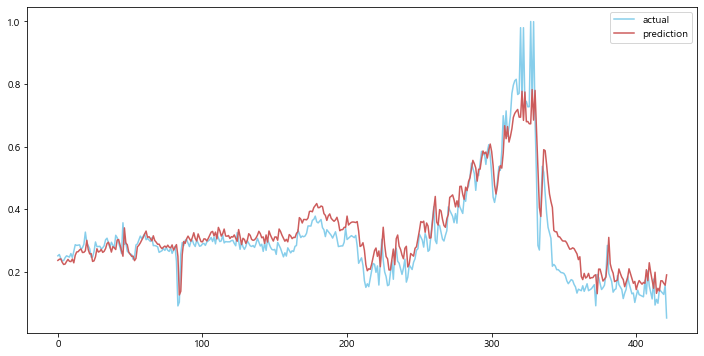

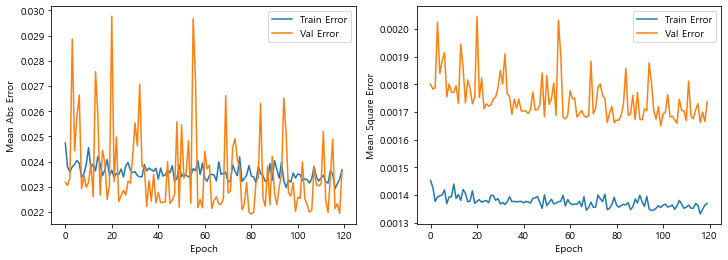

14/14 - 0s - loss: 0.0039 - mae: 0.0446 - mse: 0.0039
MAE:  0.044604
MSE:  0.003900
RMSE: 0.062450


In [17]:
tscv = TimeSeriesSplit(n_splits=5)
prediction = pd.DataFrame()

for train_index, test_index in tscv.split(input_data_X[4]):
    train_X, test_X = input_data_X[4][train_index], input_data_X[4][test_index]
    train_y, test_y = input_data_y[4][train_index], input_data_y[4][test_index]
    print('\nTRAIN 데이터셋 : ', len(train_X), ', TEST 데이터셋 : ', len(test_X))
    
    history = model_rnn.fit(train_X, train_y, epochs=EPOCHS, validation_split=0.2, verbose =False, batch_size = mini_batch_size, callbacks=[early_stop, PrintDot()])
    
    pred = model_rnn.predict(test_X)
    graph(pred, test_y)
    plot_history(history)
    
    df_pred = pd.DataFrame(pred)
    prediction = pd.concat([prediction, df_pred], ignore_index=True)
    
    loss, mae, mse = model_rnn.evaluate(test_X, test_y, verbose=2)
    
    # MAE(Mean Absolute Error)
    print("MAE:  %f" % mae)
    # MSE(Mean Squared Error)
    print("MSE:  %f" % mse)
    # RMSE(Root Mean Squared Error)
    print("RMSE: %f" % np.sqrt(mse))

In [49]:
zero_data = np.zeros(shape=(424,1))
zero = pd.DataFrame(zero_data)

preds = pd.concat([zero,prediction])
preds.reset_index(drop=True, inplace=True)

preds[preds[0] == 0] = np.nan

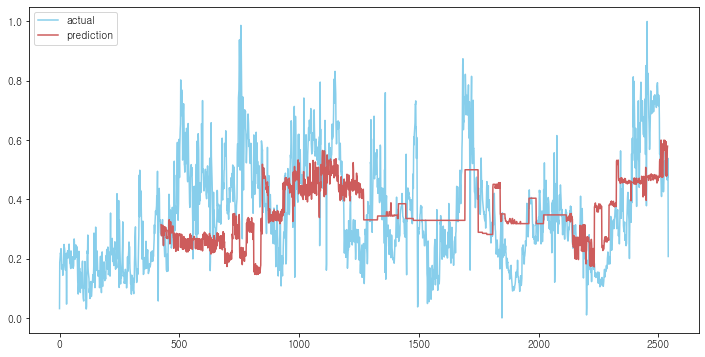

In [50]:
graph(preds, y)

<AxesSubplot:>

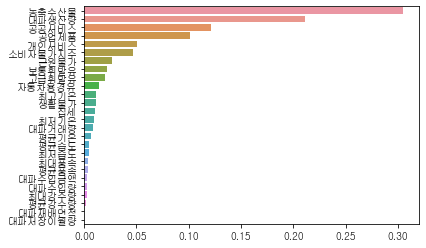

In [52]:
feature_series = pd.Series(data=model_xgb.feature_importances_, index=input_data.iloc[:,1:].columns)
feature_series = feature_series.sort_values(ascending=False) 
sns.barplot(x = feature_series, y=feature_series.index)

<AxesSubplot:>

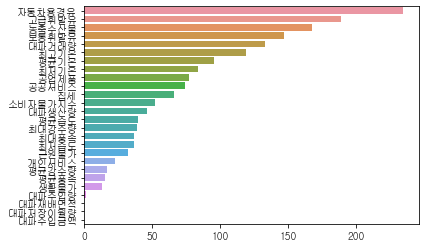

In [53]:
feature_series = pd.Series(data=model_lgbm.feature_importances_, index=input_data.iloc[:,1:].columns)
feature_series = feature_series.sort_values(ascending=False) 
sns.barplot(x = feature_series, y=feature_series.index)

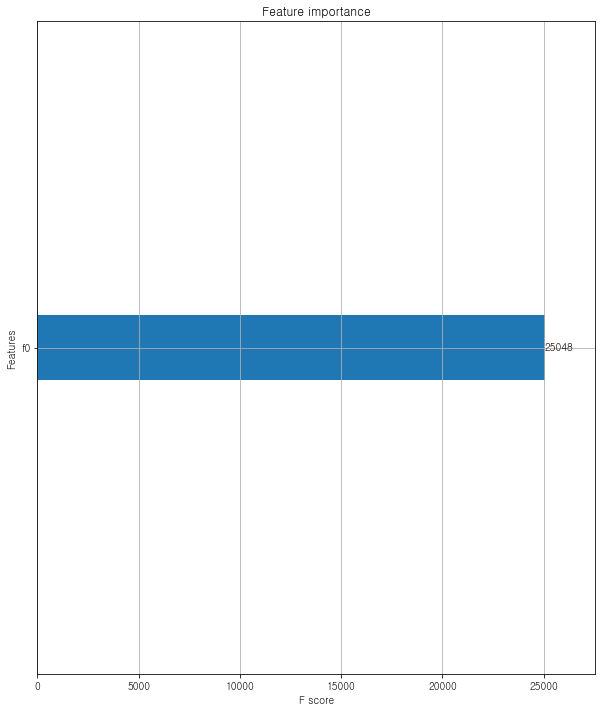

In [37]:
feature_importance(model_xgb)